In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import time 
import scipy
import investpy
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# Import data

In [29]:
ft = yf.download("LST.BK VPO.BK UVAN.BK UPOIC.BK ZM=F ZL=F ZS=F",start="2010-01-02",end="2020-08-31")
ft.fillna(method='bfill', inplace=True)
ft = ft.dropna()
ft = ft['Adj Close']
ft.head()

[*********************100%***********************]  7 of 7 completed


,LST.BK,UPOIC.BK,UVAN.BK,VPO.BK,ZL=F,ZM=F,ZS=F
Date,,,,,,,
2010-01-04,2.284665,7.659611,0.253351,2.881667,40.900002,316.000000,1049.50
2010-01-05,2.247816,7.659611,0.250262,2.881667,40.709999,319.399994,1052.25
2010-01-06,2.272381,7.659611,0.250262,2.881667,40.669998,317.899994,1050.50
2010-01-07,2.247816,7.659611,0.248717,2.881667,39.990002,307.000000,1017.75
2010-01-08,2.247816,7.659611,0.250262,2.881667,39.529999,306.799988,1013.00


In [30]:
st = yf.download("PTTEP.BK TVO.BK SCC.BK BTS.BK TNPC.BK",start="2010-01-02",end="2020-08-31")
st.fillna(method='bfill', inplace=True)
st = st.dropna()
st = st['Adj Close']
st.head()

[*********************100%***********************]  5 of 5 completed


,BTS.BK,PTTEP.BK,SCC.BK,TNPC.BK,TVO.BK
Date,,,,,
2010-01-04,2.294183,91.686096,159.190170,0.380774,9.123015
2010-01-05,2.294183,92.628090,159.190170,0.380774,9.123015
2010-01-06,2.255942,93.570053,157.140518,0.380774,9.173982
2010-01-07,2.255942,92.628090,154.407623,0.380774,9.224945
2010-01-08,2.255942,93.256287,155.090866,0.380774,9.275917


In [31]:
PTT = ft.join(st['TVO.BK'])
PTT = PTT.dropna()
PTT 

,LST.BK,UPOIC.BK,UVAN.BK,VPO.BK,ZL=F,ZM=F,ZS=F,TVO.BK
Date,,,,,,,,
2010-01-04,2.284665,7.659611,0.253351,2.881667,40.900002,316.000000,1049.50,9.123015
2010-01-05,2.247816,7.659611,0.250262,2.881667,40.709999,319.399994,1052.25,9.123015
2010-01-06,2.272381,7.659611,0.250262,2.881667,40.669998,317.899994,1050.50,9.173982
2010-01-07,2.247816,7.659611,0.248717,2.881667,39.990002,307.000000,1017.75,9.224945
2010-01-08,2.247816,7.659611,0.250262,2.881667,39.529999,306.799988,1013.00,9.275917
...,...,...,...,...,...,...,...,...
2020-08-24,4.340000,3.200000,4.422586,0.360000,31.660000,289.100006,899.75,27.250000
2020-08-25,4.340000,3.420000,4.500862,0.360000,31.980000,291.600006,913.75,27.250000
2020-08-26,4.400000,3.260000,4.540000,0.350000,32.240002,291.500000,924.50,28.000000


In [32]:
# df = pd.read_csv('BZ=F.csv')
# df = df.rename(columns={'วันเดือนปี' : 'Date','ล่าสุด' : 'BZ=F'})
# df = df[['BZ=F']]

# PTT = PTT.merge(df)
# PTT

# Visualize the Time Series

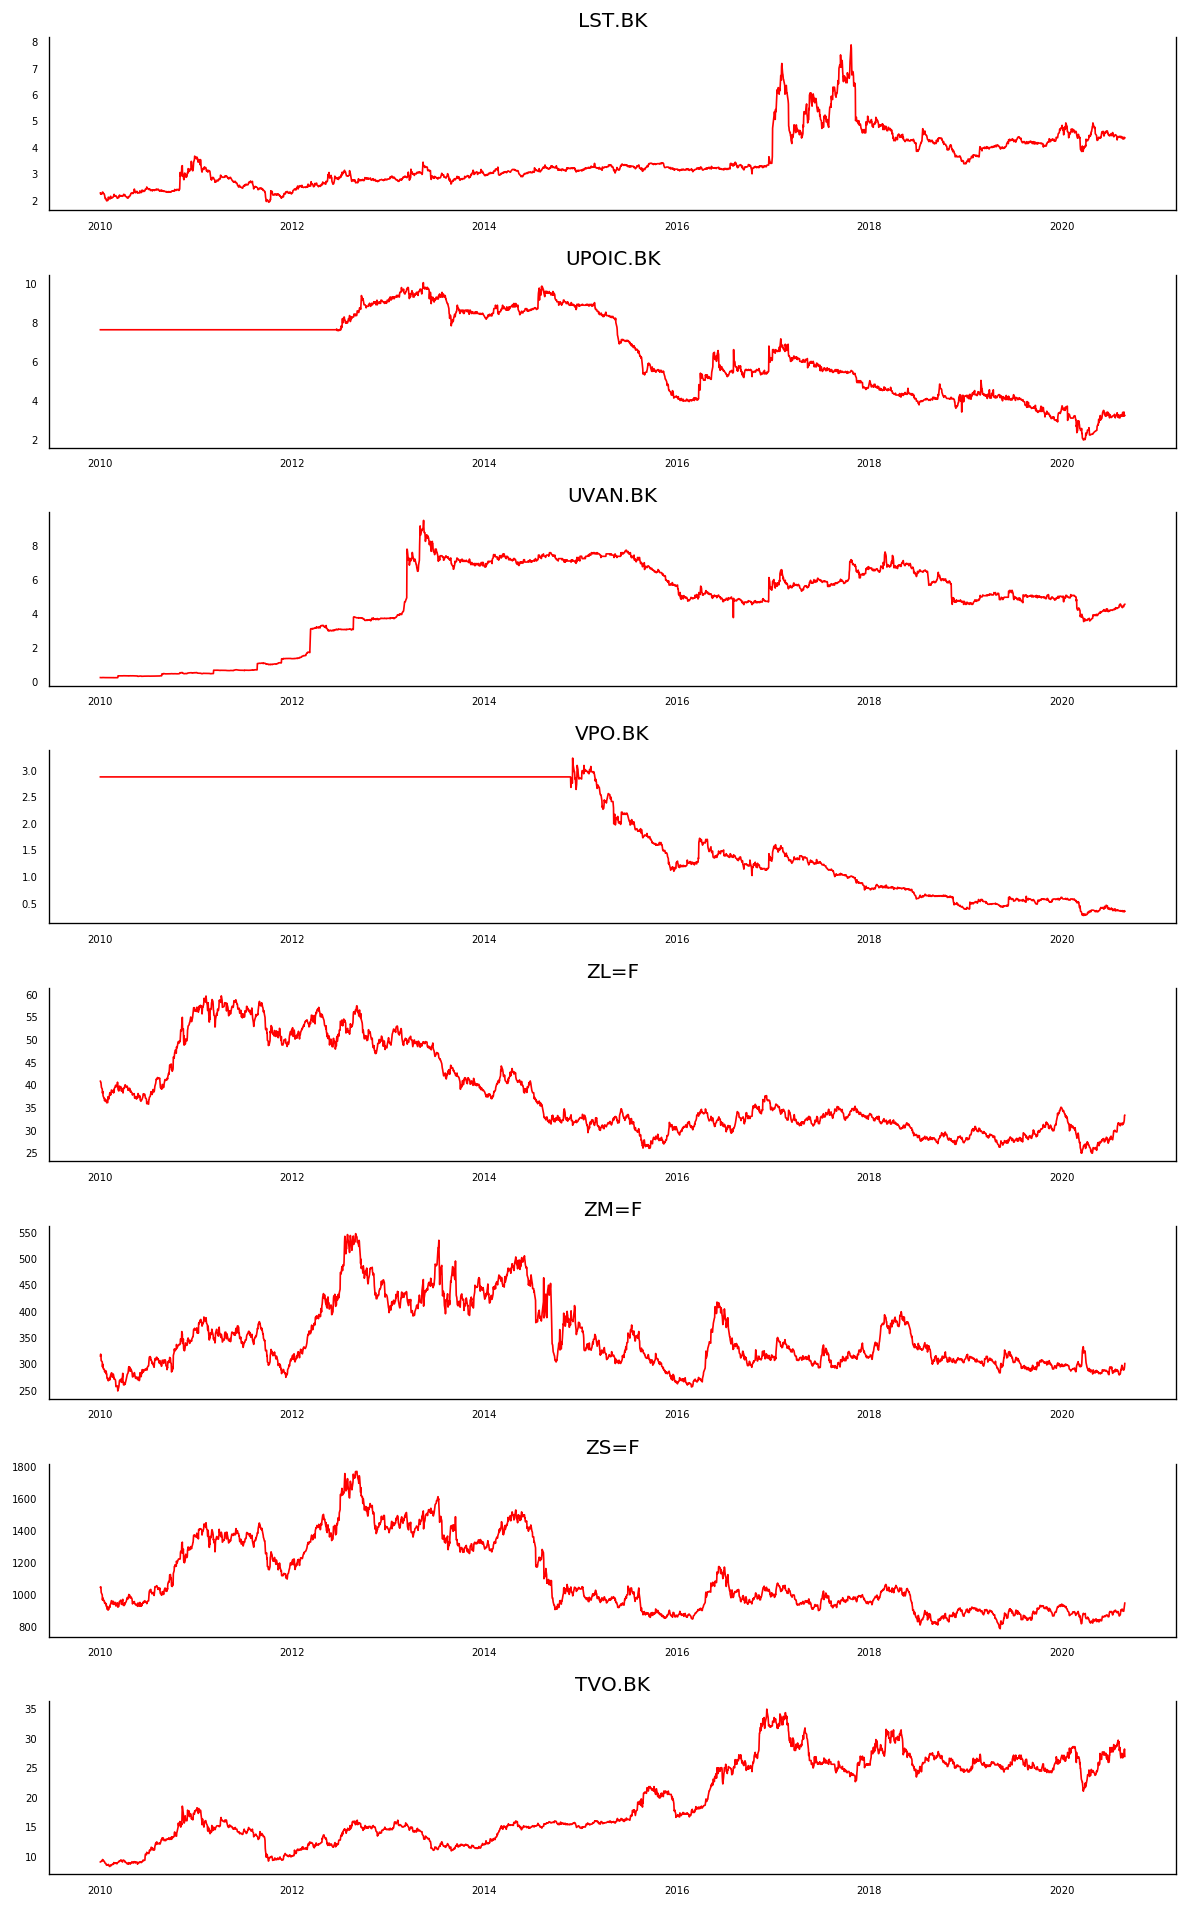

In [33]:
fig, axes = plt.subplots(nrows=len(PTT.columns), ncols=1, dpi=120, figsize=(10,16))
for i, ax in enumerate(axes.flatten()):
    data = PTT[PTT.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(PTT.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Correlation

In [34]:
PTT.corr().loc[['TVO.BK']]

,LST.BK,UPOIC.BK,UVAN.BK,VPO.BK,ZL=F,ZM=F,ZS=F,TVO.BK
TVO.BK,0.804877,-0.764917,0.359306,-0.884948,-0.639944,-0.361188,-0.575808,1.0


# Testing Causation using Granger’s Causality Test

In [35]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=24
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    PTT = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in PTT.columns:
        for r in PTT.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            PTT.loc[r, c] = min_p_value
    PTT.columns = [var + '_x' for var in variables]
    PTT.index = [var + '_y' for var in variables]
    return PTT

grangers_causation_matrix(PTT, variables = PTT.columns).loc[['TVO.BK_y']]   

c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, b

,LST.BK_x,UPOIC.BK_x,UVAN.BK_x,VPO.BK_x,ZL=F_x,ZM=F_x,ZS=F_x,TVO.BK_x
TVO.BK_y,0.0286,0.028,0.7363,0.0081,0.0,0.0002,0.0,1.0


# Cointegration Test

In [36]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(PTT, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(PTT,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(PTT.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(PTT)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
LST.BK ::  171.91    > 143.6691  =>   True
UPOIC.BK ::  126.07    > 111.7797  =>   True
UVAN.BK ::  93.25     > 83.9383   =>   True
VPO.BK ::  65.73     > 60.0627   =>   True
ZL=F   ::  40.64     > 40.1749   =>   True
ZM=F   ::  18.47     > 24.2761   =>   False
ZS=F   ::  6.53      > 12.3212   =>   False
TVO.BK ::  0.06      > 4.1296    =>   False


# Split the Series into Training and Testing Data

In [37]:
nobs = 7
ft_train, ft_test = PTT[0:-nobs], PTT[-nobs:]

# Check size
print(ft_train.shape)  
print(ft_test.shape)  
ft_train

(2596, 8)
(7, 8)


,LST.BK,UPOIC.BK,UVAN.BK,VPO.BK,ZL=F,ZM=F,ZS=F,TVO.BK
Date,,,,,,,,
2010-01-04,2.284665,7.659611,0.253351,2.881667,40.900002,316.000000,1049.50,9.123015
2010-01-05,2.247816,7.659611,0.250262,2.881667,40.709999,319.399994,1052.25,9.123015
2010-01-06,2.272381,7.659611,0.250262,2.881667,40.669998,317.899994,1050.50,9.173982
2010-01-07,2.247816,7.659611,0.248717,2.881667,39.990002,307.000000,1017.75,9.224945
2010-01-08,2.247816,7.659611,0.250262,2.881667,39.529999,306.799988,1013.00,9.275917
...,...,...,...,...,...,...,...,...
2020-08-13,4.440000,3.220000,4.540000,0.370000,31.600000,290.100006,907.25,26.750000
2020-08-14,4.380000,3.280000,4.442155,0.360000,31.530001,289.700012,903.50,27.500000
2020-08-17,4.400000,3.200000,4.422586,0.360000,31.299999,298.299988,912.50,27.250000


# Check for Stationarity and Make the Time Series Stationary

In [38]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [39]:
# ADF Test on each column
for name, column in ft_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "LST.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7273
 No. Lags Chosen       = 22
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0694. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "UPOIC.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.4298
 No. Lags Chosen       = 5
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.905. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "UVAN.BK" 
    -----------------------------------------------
 Null Hypothesis: Data ha

In [40]:
# 1st difference
ft_differenced = ft_train.diff().dropna()

In [41]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in ft_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "LST.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.8738
 No. Lags Chosen       = 27
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "UPOIC.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -23.1191
 No. Lags Chosen       = 4
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "UVAN.BK" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

In [42]:
# # Second Differencing
# ft_differenced = ft_differenced.diff().dropna()

In [43]:
# # ADF Test on each column of 2nd Differences Dataframe
# for name, column in ft_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

# Select the Order (P) of VAR model

In [44]:
model = VAR(ft_differenced)
for i in list(range(1,24)):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1
AIC :  -17.355582085973936
BIC :  -17.192903266285768
FPE :  2.9011258353158655e-08
HQIC:  -17.296632667527426 

Lag Order = 2
AIC :  -17.336200275649343
BIC :  -17.028819779377358
FPE :  2.9579071409054904e-08
HQIC:  -17.22481357738105 

Lag Order = 3
AIC :  -17.32085300995344
BIC :  -16.86867823700034
FPE :  3.0036629271996914e-08
HQIC:  -17.156993418846707 

Lag Order = 4
AIC :  -17.299719900384105
BIC :  -16.70265815446809
FPE :  3.067834271231535e-08
HQIC:  -17.083351765352123 

Lag Order = 5
AIC :  -17.28362147176946
BIC :  -16.541579960287027
FPE :  3.117652866127996e-08
HQIC:  -17.014709103599934 

Lag Order = 6
AIC :  -17.267323996696266
BIC :  -16.380209830584793
FPE :  3.1689265788893256e-08
HQIC:  -16.945831667996007 

Lag Order = 7
AIC :  -17.244356348291447
BIC :  -16.21207654189149
FPE :  3.242619183834271e-08
HQIC:  -16.870248293430876 

Lag Order = 8
AIC :  -17.21806019031237
BIC :  -16.040521661229754
FPE :  3.3291106013472473e-08
HQIC:  -16.791300605369

In [45]:
#Lag Order = 3
x = model.select_order(maxlags=4)
x.summary()

,AIC,BIC,FPE,HQIC
0,-17.28,-17.26*,3.123e-08,-17.28
1,-17.35*,-17.19,2.922e-08*,-17.29*
2,-17.33,-17.02,2.970e-08,-17.22
3,-17.32,-16.87,3.012e-08,-17.15
4,-17.30,-16.70,3.068e-08,-17.08


# Train the VAR Model of Selected Order(p)

In [46]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 19, Nov, 2020
Time:                     23:36:14
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -17.1929
Nobs:                     2594.00    HQIC:                  -17.2966
Log likelihood:          -6863.62    FPE:                2.90113e-08
AIC:                     -17.3556    Det(Omega_mle):     2.82184e-08
--------------------------------------------------------------------
Results for equation LST.BK
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.000815         0.001691            0.482           0.630
L1.LST.BK          -0.025415         0.020153           -1.261           0.207
L1.UPOIC.BK         0.020689         0.017399            1.189     

# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [47]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(PTT.columns, out):
    print( col,':', round(val, 2))

LST.BK : 2.01
UPOIC.BK : 2.03
UVAN.BK : 2.0
VPO.BK : 2.01
ZL=F : 2.0
ZM=F : 2.0
ZS=F : 2.0
TVO.BK : 2.01


# Forecast VAR model using statsmodels

In [48]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = ft_differenced.values[-lag_order:]
forecast_input

1


array([[ 0.        ,  0.13999987, -0.01956892,  0.        ,  0.09000015,
        -0.5       ,  0.5       , -0.25      ]])

In [49]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
ft_forecast = pd.DataFrame(fc, index=PTT.index[-nobs:], columns=PTT.columns + '_1d')
ft_forecast


,LST.BK_1d,UPOIC.BK_1d,UVAN.BK_1d,VPO.BK_1d,ZL=F_1d,ZM=F_1d,ZS=F_1d,TVO.BK_1d
Date,,,,,,,,
2020-08-20,0.000615,-0.032104,0.010522,0.000189,0.018118,0.067982,0.172527,0.000084
2020-08-21,0.000535,0.004656,-0.000185,-0.001321,-0.004207,-0.054685,-0.088509,0.010460
2020-08-24,0.000921,-0.003010,0.001945,-0.000893,-0.003375,-0.000062,-0.044560,0.006196
2020-08-25,0.000807,-0.001391,0.001516,-0.000984,-0.003468,-0.010700,-0.054642,0.007163
2020-08-26,0.000834,-0.001734,0.001604,-0.000965,-0.003473,-0.008797,-0.053467,0.006952
2020-08-27,0.000828,-0.001661,0.001586,-0.000969,-0.003471,-0.009188,-0.053674,0.006995
2020-08-28,0.000830,-0.001677,0.001590,-0.000968,-0.003471,-0.009104,-0.053628,0.006986


# Invert the transformation to get the real forecast

In [50]:
def invert_transformation(ft_train, ft_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    ft_fc = ft_forecast.copy()
    columns = ft_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            ft_fc[str(col)+'_1d'] = (ft_train[col].iloc[-1]-ft_train[col].iloc[-2]) + ft_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        ft_fc[str(col)+'_forecast'] = ft_train[col].iloc[-1] + ft_fc[str(col)+'_1d'].cumsum()
    return ft_fc

In [51]:
ft_results = invert_transformation(ft_train, ft_forecast, second_diff=False)        
ft_results.loc[:, ["LST.BK_forecast" ,"UPOIC.BK_forecast", "UVAN.BK_forecast", "VPO.BK_forecast" ,"ZL=F_forecast","ZM=F_forecast","ZS=F_forecast","TVO.BK_forecast" ]]

,LST.BK_forecast,UPOIC.BK_forecast,UVAN.BK_forecast,VPO.BK_forecast,ZL=F_forecast,ZM=F_forecast,ZS=F_forecast,TVO.BK_forecast
Date,,,,,,,,
2020-08-20,4.400615,3.307896,4.374401,0.370189,31.688118,295.767994,912.672527,27.250084
2020-08-21,4.401151,3.312553,4.374216,0.368868,31.683911,295.713310,912.584018,27.260545
2020-08-24,4.402072,3.309543,4.376162,0.367974,31.680536,295.713248,912.539458,27.266741
2020-08-25,4.402879,3.308152,4.377678,0.366991,31.677068,295.702548,912.484816,27.273904
2020-08-26,4.403713,3.306417,4.379282,0.366026,31.673595,295.693751,912.431349,27.280855
2020-08-27,4.404542,3.304756,4.380868,0.365058,31.670124,295.684563,912.377675,27.287851
2020-08-28,4.405371,3.303079,4.382458,0.364090,31.666653,295.675458,912.324048,27.294837


# Plot of Forecast vs Actuals

Forecast Accuracy of: TVO
mae (Mean Absolute Error) :  0.3611
rmse (Root Mean Square Error) :  0.5044
mape (Mean absolute percentage error) :  1.3034


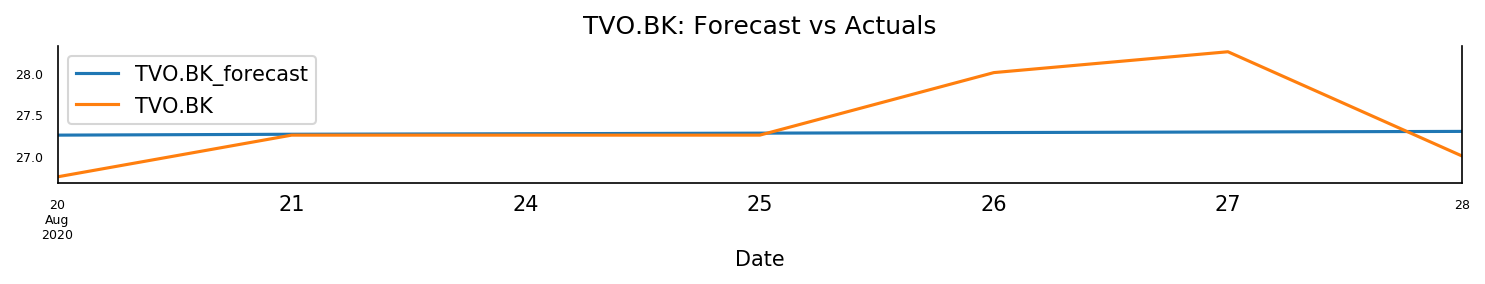

In [52]:


fig, axes = plt.subplots(nrows=1, ncols=1, dpi=150, figsize=(10,2))
ft_results['TVO.BK'+'_forecast'].plot(legend=True).autoscale(axis='x',tight=True)
ft_test['TVO.BK'].plot(legend=True );
axes.set_title('TVO.BK' + ": Forecast vs Actuals")
axes.xaxis.set_ticks_position('none')
axes.yaxis.set_ticks_position('none')
axes.spines["top"].set_alpha(0)
axes.tick_params(labelsize=6)

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
#  
#     n = train.shape[0]
#     d = np.abs(  np.diff( train) ).sum()/(n-1)
    
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     mase = np.mean(np.abs(actual - forecast ))/d
    
#     me = np.mean(forecast - actual)             # ME
#     mpe = np.mean((forecast - actual)/actual)   # MPE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mae (Mean Absolute Error)': mae, 
            'rmse (Root Mean Square Error)':rmse,
            'mape (Mean absolute percentage error)':mape*100})

print('Forecast Accuracy of: TVO')
accuracy_prod = forecast_accuracy(ft_results['TVO.BK_forecast'].values, ft_test['TVO.BK'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
plt.tight_layout();



#  Plot of Forecast vs Actuals ( Forecast 1 year )

In [54]:
start = 0
end = 2441
nobs = 7
max_row = len(PTT) - end

forecast_results = pd.DataFrame()
forecast_test = PTT[end:]


while max_row > 0 :
    if(max_row < nobs):
        ft_train, ft_test = PTT[start:end] , PTT[end:end+max_row]
    else :
        ft_train, ft_test = PTT[start:end] , PTT[end:end+nobs]

    ft_differenced = ft_train.diff().dropna()

    model = VAR(ft_differenced)

    model_fitted = model.fit(2)
    model_fitted.summary()

    lag_order = model_fitted.k_ar

    # Input data for forecasting
    forecast_input = ft_differenced.values[-lag_order:]


    # Forecast
    if(max_row < nobs):
        fc = model_fitted.forecast(y=forecast_input, steps=max_row)
        ft_forecast = pd.DataFrame(fc, index=PTT.index[end:end+max_row], columns=PTT.columns + '_1d')
    else:
        fc = model_fitted.forecast(y=forecast_input, steps=nobs)
        ft_forecast = pd.DataFrame(fc, index=PTT.index[end:end+nobs], columns=PTT.columns + '_1d')


    ft_results = invert_transformation(ft_train, ft_forecast, second_diff=False)        
    ft_results.loc[:, ["TVO.BK_forecast" ]]
    
    forecast_results = forecast_results.append(ft_results) 
    
    if(max_row < nobs):
        start += max_row
        end += max_row
        max_row -= max_row
        break    
        
    start += nobs
    end += nobs
    max_row -= nobs
    



c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\administrator\appdata\local\programs\python\python37\lib\site-pa

In [55]:
month = 8
day = 28
New_forecast = pd.DataFrame()
for i in range(0,7):
    day += 1
    if(day > 31):
        month +=1
        day=1
    date = '2020'+'-'+str(month)+'-'+str(day)
    new_date = pd.DataFrame(index = [date])
    New_forecast = New_forecast.append(new_date)
    
ft_train = PTT[start:end] 

ft_differenced = ft_train.diff().dropna()

model = VAR(ft_differenced)

model_fitted = model.fit(2)
model_fitted.summary()

lag_order = model_fitted.k_ar

# Input data for forecasting
forecast_input = ft_differenced.values[-lag_order:]


# Forecast
# if(max_row < nobs):
#     fc = model_fitted.forecast(y=forecast_input, steps=max_row)
#     ft_forecast = pd.DataFrame(fc, index=PTT.index[end:end+max_row], columns=PTT.columns + '_1d')
# else:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
ft_forecast_n = pd.DataFrame(fc, index=New_forecast.index[0:7], columns=PTT.columns + '_1d')


ft_results_n = invert_transformation(ft_train, ft_forecast_n, second_diff=False)        
ft_results_n.loc[:, ["TVO.BK_forecast" ]]

forecast_results_n = ft_results_n
forecast_results_n.index.names = ['Date']

c:\users\administrator\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [56]:
forecast_results.loc[:, ["TVO.BK_forecast" ]]

,TVO.BK_forecast
Date,
2020-01-02,26.710663
2020-01-03,26.721908
2020-01-06,26.730718
2020-01-07,26.737666
2020-01-08,26.744825
...,...
2020-08-24,27.529705
2020-08-25,27.535568
2020-08-26,27.541400


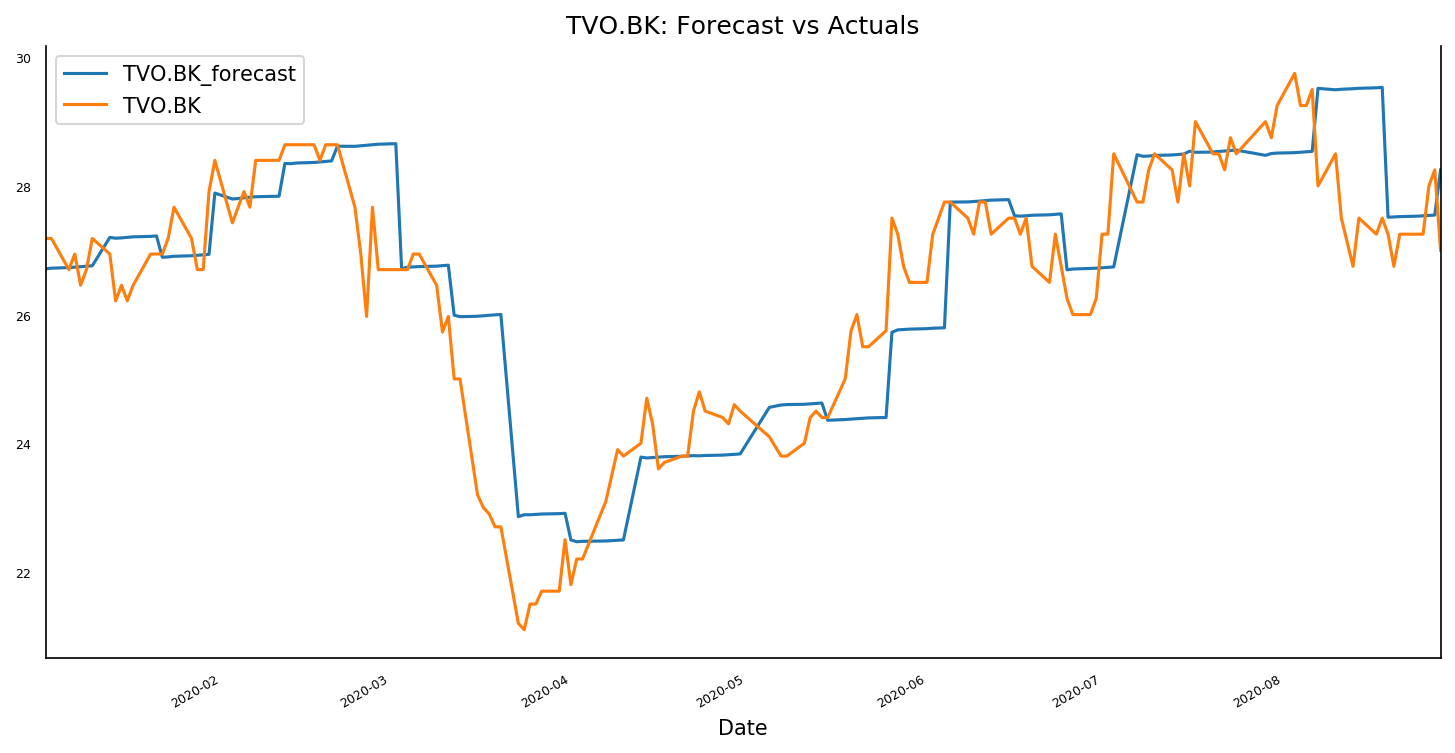

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=150, figsize=(12,6))
forecast_results['TVO.BK'+'_forecast'].plot(legend=True).autoscale(axis='x',tight=True)
forecast_test['TVO.BK'].plot(legend=True );
axes.set_title('TVO.BK' + ": Forecast vs Actuals")
axes.xaxis.set_ticks_position('none')
axes.yaxis.set_ticks_position('none')
axes.spines["top"].set_alpha(0)
axes.tick_params(labelsize=6)

In [58]:
forecast_results_n.loc[:, ["TVO.BK_forecast" ]]

,TVO.BK_forecast
Date,
2020-8-29,27.104658
2020-8-30,27.178029
2020-8-31,27.181849
2020-9-1,27.183636
2020-9-2,27.189765
2020-9-3,27.195931
2020-9-4,27.201735


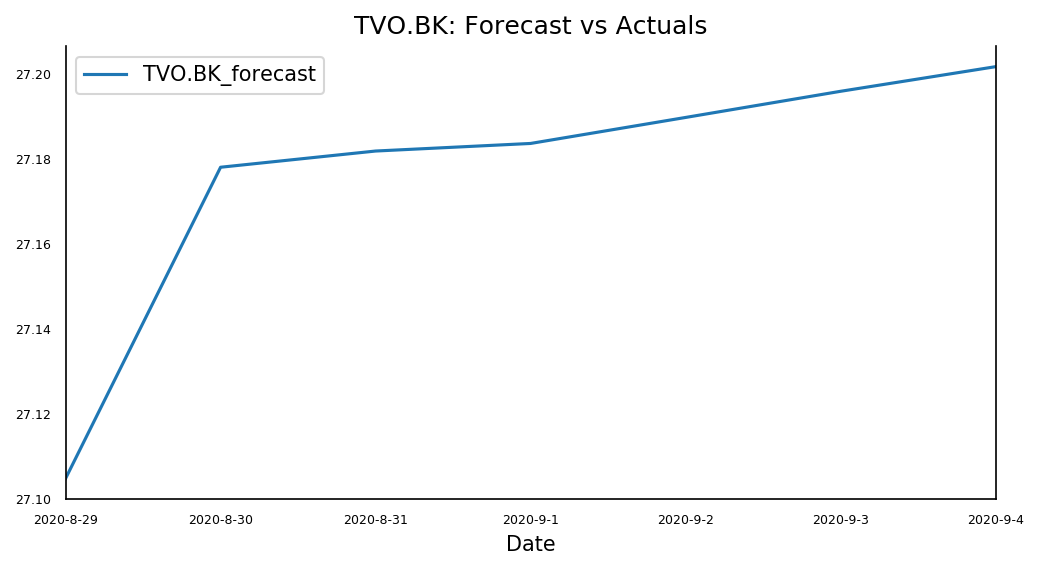

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=150, figsize=(8,4))
forecast_results_n['TVO.BK'+'_forecast'].plot(legend=True).autoscale(axis='x',tight=True)
axes.set_title('TVO.BK' + ": Forecast vs Actuals")
axes.xaxis.set_ticks_position('none')
axes.yaxis.set_ticks_position('none')
axes.spines["top"].set_alpha(0)
axes.tick_params(labelsize=6)

# Evaluate the Forecasts

In [60]:
print('Forecast Accuracy of: TVO\n')
accuracy_prod = forecast_accuracy(forecast_results['TVO.BK_forecast'].values, forecast_test['TVO.BK'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))
plt.tight_layout();

Forecast Accuracy of: TVO

mae (Mean Absolute Error) :  0.751
rmse (Root Mean Square Error) :  1.0328
mape (Mean absolute percentage error) :  2.936


<Figure size 432x288 with 0 Axes>